# 3. Content Based filtering

In [1]:
!pip install gensim
!pip install jieba
!pip install underthesea

     |████████████████████████████████| 7.6 MB 4.3 MB/s 
     |████████████████████████████████| 581 kB 52.3 MB/s 
     |████████████████████████████████| 743 kB 37.4 MB/s 
     |████████████████████████████████| 235 kB 48.5 MB/s 


In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

%cd '/content/gdrive/My Drive/LDS0_K273_ONLINE_DoThiPhuong/Topic_2/'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS0_K273_ONLINE_DoThiPhuong/Topic_2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
warnings.filterwarnings('ignore')

In [4]:
# đọc dữ liệu
products = pd.read_csv('Products.csv')
reviews = pd.read_csv('Reviews.csv')

In [5]:
products.head(2)

,item_id,name,description
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...


In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4373 entries, 0 to 4372
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item_id      4373 non-null   int64 
 1   name         4373 non-null   object
 2   description  4370 non-null   object
dtypes: int64(1), object(2)
memory usage: 102.6+ KB


In [7]:
products.shape

(4373, 3)

In [8]:
products = products[products['name'].notnull()]

In [9]:
products['name_description'] = products.name + products.description

In [10]:
products = products[products['name_description'].notnull()]

In [11]:
products['name_description_pre'] = products['name_description'].apply(lambda x: word_tokenize(x, format = 'text'))

In [12]:
type(products)

pandas.core.frame.DataFrame

In [13]:
products.shape

(4370, 5)

In [14]:
products.head(2)

,item_id,name,description,name_description,name_description_pre
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,Tai_nghe Bluetooth_Inpods 12 - Cảm_biến vân ta...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,Tai nghe bluetooth không dây F9 True wireless ...,Tai_nghe bluetooth không dây F9_True wireless ...


In [15]:
STOP_WORD_FILE = 'vietnamese-stopwords.txt'

In [16]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
  stop_words = file.read()

stop_words = stop_words.split('\n')

In [17]:
tf = TfidfVectorizer(analyzer= 'word', min_df = 0, stop_words=stop_words)

In [18]:
tfidf_matrix = tf.fit_transform(products.name_description_pre)

## 3.1. Áp dụng Cosine_similarity

In [19]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [20]:
cosine_similarities

array([[1.        , 0.35929855, 0.08313389, ..., 0.01771502, 0.0095737 ,
        0.05917742],
       [0.35929855, 1.        , 0.08321854, ..., 0.01520767, 0.02756314,
        0.08715747],
       [0.08313389, 0.08321854, 1.        , ..., 0.03603776, 0.02342419,
        0.06634264],
       ...,
       [0.01771502, 0.01520767, 0.03603776, ..., 1.        , 0.0063396 ,
        0.03202514],
       [0.0095737 , 0.02756314, 0.02342419, ..., 0.0063396 , 1.        ,
        0.04105841],
       [0.05917742, 0.08715747, 0.06634264, ..., 0.03202514, 0.04105841,
        1.        ]])

In [21]:
cosine_similarities.shape

(4370, 4370)

In [22]:
type(cosine_similarities)

numpy.ndarray

In [25]:
def recommendation_cosine(id_view_product,data_file,matrix_file):
    df = data_file
    cosine_sim = matrix_file
    matrix = pd.DataFrame(cosine_sim,columns=df.item_id.values,index=df.item_id.values).reset_index()
    df_sim = matrix.loc[matrix[id_view_product]>=0.0,["index",id_view_product]].sort_values(id_view_product,ascending=False)
    result = pd.merge(df_sim, df, left_on="index",right_on="item_id")
    result.rename(columns={id_view_product:"score"},inplace=True)
    result = result[["score","item_id","name","name_description_pre"]].reset_index(drop=True).iloc[1:6,:]
    text = " ".join(content for content in result.name_description_pre)
    return result, text

In [26]:
id_view_product = 48102821
df_recommend_cosine, text = recommendation_cosine(id_view_product=id_view_product,
                             data_file = products,               
                             matrix_file = cosine_similarities)
df_recommend_cosine

,score,item_id,name,name_description_pre
1,0.434966,56365197,"Tai nghe bluetooth không dây i12 TWS 5.0, thiế...","Tai_nghe bluetooth không dây i12 TWS_5.0 , thi..."
2,0.387165,22413470,Tai Nghe Bluetooth Air.podes Cảm Ứng Công Nghệ...,Tai_Nghe Bluetooth_Air ._podes Cảm_Ứng Công_Ng...
3,0.383320,50319688,Tai Nghe Bluetooth Mini I12 Tws V5.0 (Trắng) N...,Tai_Nghe Bluetooth Mini I12 Tws V5 ._0 ( Trắng...
4,0.371535,72928043,Tai Nghe Bluetooth Amoi F9 kèm Củ Sạc 1A và Cá...,Tai_Nghe Bluetooth_Amoi_F9 kèm Củ_Sạc_1A và Cá...
5,0.370487,56885678,Tai Nghe Bluetooth TWS F9 Tai Nghe Nhét Hai T...,Tai_Nghe Bluetooth TWS F9 Tai_Nghe Nhét Hai Ta...


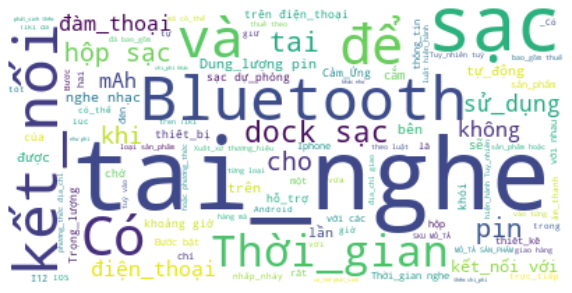

In [27]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()